# Estimation of MODIS-like Surface-Spectral Reflectance from Geostationary Satellites using Deep Neural Networks 

## Setup

In [1]:
%matplotlib inline
import argparse
import datetime
import glob
import os

import gdal
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = "8,8"
import scipy.ndimage
gdal.VersionInfo()

'2020200'

In [2]:
raw_dir = "modis"
layers = ["250m 16 days composite day of the year", # doy 1st for compositing reasons
          "250m 16 days NDVI", 
          "250m 16 days NIR reflectance"] 
raw_files = glob.glob(raw_dir + '/*.hdf')
raw_files[:5]

['modis/MOD13Q1.A2017257.h16v02.006.2017276133212.hdf',
 'modis/MOD13Q1.A2017257.h25v05.006.2017276133105.hdf',
 'modis/MOD13Q1.A2017257.h25v06.006.2017276132955.hdf',
 'modis/MOD13Q1.A2017273.h28v10.006.2017290090340.hdf',
 'modis/MOD13Q1.A2017257.h28v04.006.2017276133137.hdf']

In [3]:
filepath = [f for f in raw_files if 'h12v09' in f][0] # set day here
day_of_year = int(filepath.split('.')[4][4:7])
filepath, day_of_year

('modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf', 276)

In [4]:
ds = gdal.Open(filepath, gdal.GA_ReadOnly)
datasets = ds.GetSubDatasets()
datasets[:2]

[('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NDVI',
  '[4800x4800] 250m 16 days NDVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)'),
 ('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days EVI',
  '[4800x4800] 250m 16 days EVI MODIS_Grid_16DAY_250m_500m_VI (16-bit integer)')]

## Day of Year

In [5]:
doy_layer = ""
for dataset in datasets:
    if layers[0] in dataset[0]:
        doy_layer = dataset[0]
file_type = doy_layer.split(' ')[3].lower()
doy_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days composite day of the year',
 'composite')

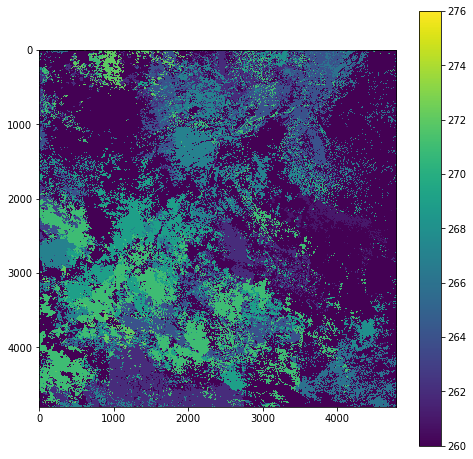

In [6]:
doy_modis = gdal.Open(doy_layer)
plt.imshow(doy_modis.ReadAsArray())
plt.clim(day_of_year - 16, day_of_year)
_ = plt.colorbar()

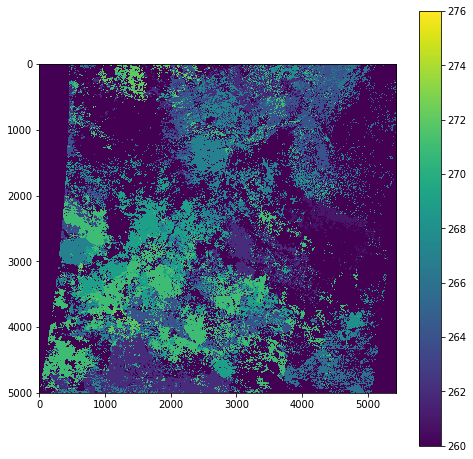

In [7]:
output = filepath.replace('.hdf', '.' + file_type + ".tif")
gdal.Warp(output, doy_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
doy_arr = data.ReadAsArray()
plt.imshow(doy_arr)
plt.clim(day_of_year - 16, day_of_year)
_ = plt.colorbar()


## Near Infrared

In [8]:
nir_layer = ""
for dataset in datasets:
    if layers[2] in dataset[0]:
        nir_layer = dataset[0]
        
file_type = nir_layer.split(' ')[3].lower()
nir_layer, file_type

('HDF4_EOS:EOS_GRID:"modis/MOD13Q1.A2017257.h12v09.006.2017276132700.hdf":MODIS_Grid_16DAY_250m_500m_VI:250m 16 days NIR reflectance',
 'nir')

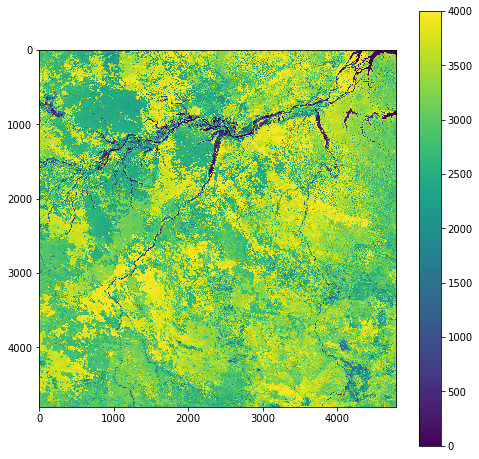

In [9]:
nir_modis = gdal.Open(nir_layer)
nir_modis.ReadAsArray()
plt.imshow(nir_modis.ReadAsArray())
plt.clim(0,4000)
_ = plt.colorbar()

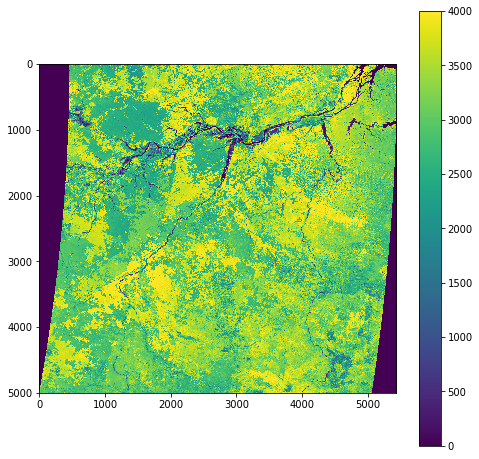

In [10]:
output = filepath.replace('.hdf', '.' + file_type + ".tif")
gdal.Warp(output, nir_modis, dstSRS='EPSG:3857')
data = gdal.Open(output)
nir_arr = data.ReadAsArray()
plt.imshow(nir_arr)
plt.clim(0,4000)
_ = plt.colorbar()

In [11]:
ulx, xres, xskew, uly, yskew, yres = nir_modis.GetGeoTransform()
lrx = ulx + (nir_modis.RasterXSize * xres)
lry = uly + (nir_modis.RasterYSize * yres)
xres, yres

(231.65635826395825, -231.65635826395834)

In [12]:
srs = nir_modis.GetProjection()
srs

'PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'

## GOES-16 NIR

In [13]:
doy = int(filepath.split('.')[1][5:])
year = int(filepath.split('.')[4][0:4])
date = datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)
doy

257

In [14]:
from netCDF4 import Dataset

In [15]:
goes_dir = "goes"
preprocessed = False
if not preprocessed:
    veggies = ['NETCDF:' + f + ':Rad' for f in sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/*M3C03*.nc'))] # sort
else:
    veggies = sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/t*M3C03*.nc')) # sort
veggies[:3]

['NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571800379_e20172571811146_c20172571811197.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571815379_e20172571826146_c20172571826188.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571830379_e20172571841146_c20172571841193.nc:Rad']

$\uparrow$ These are the GOES-16 Veggie/NIR Band (band 3) files at 1 km resolution

In [16]:
if not preprocessed:
    red = ['NETCDF:' + f + ':Rad' for f in sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/*M3C02*.nc'))] # sort
else:
    red = sorted(glob.glob(goes_dir + '/' + str(doy) + '/18/t*M3C02*.nc')) # sort
red[:3]

['NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C02_G16_s20172571800379_e20172571811146_c20172571811182.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C02_G16_s20172571815379_e20172571826146_c20172571826178.nc:Rad',
 'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C02_G16_s20172571830379_e20172571841146_c20172571841188.nc:Rad']

$\uparrow$ These are the GOES-16 Red Band (band 2) files at 0.5 km resolution

In [17]:
# f = goes_files[1]
translated = glob.glob(goes_dir + '/' + str(doy) + '/18/*M3C02*')
goes_net = Dataset(veggies[3].split(':')[1], "r", format="NETCDF4")
goes_arr = goes_net['Rad'][:].data

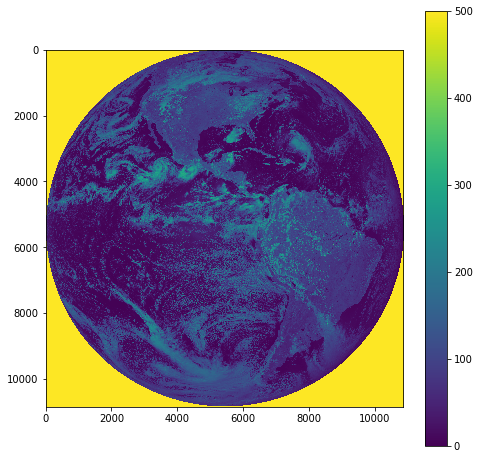

In [18]:
plt.imshow(goes_arr)
plt.clim(0,500)
_ = plt.colorbar()

In [19]:
b = gdal.Open(veggies[3])
wkt = b.GetProjection()
wkt

'PROJCS["unnamed",GEOGCS["unknown",DATUM["unknown",SPHEROID["Spheroid",6378137,298.2572221]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Geostationary_Satellite"],PARAMETER["central_meridian",-89.5],PARAMETER["satellite_height",35786023],PARAMETER["false_easting",0],PARAMETER["false_northing",0],EXTENSION["PROJ4","+proj=geos +lon_0=-89.5 +h=35786023 +x_0=0 +y_0=0 +ellps=GRS80 +units=m +no_defs  +sweep=x"]]'

In [20]:
veggies[3]

'NETCDF:goes/257/18/OR_ABI-L1b-RadF-M3C03_G16_s20172571845379_e20172571856146_c20172571856196.nc:Rad'

In [21]:
def warp(outputfn, inputfn, dstSRS='EPSG:3857'):
    os.system('gdalwarp -t_srs "{}" {} {}'.format(dstSRS, inputfn, outputfn))
    return gdal.Open(outputfn)
t = gdal.Warp('test5.tif', veggies[3], dstSRS='EPSG:3857')
t.GetProjection()

'PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'

In [26]:
cut = gdal.Warp('cutout.tif', t, outputBoundsSRS=srs, outputBounds=[ulx, lry, lrx, uly])
culx, cxres, cxskew, culy, cyskew, cyres = cut.GetGeoTransform()
xres, cxres
xres / cxres

0.10894915764183315

In [27]:
# for m in [nir_modis, data, cut]:
#     ulx, xres, xskew, uly, yskew, yres = m.GetGeoTransform()
#     lrx = ulx + (m.RasterXSize * xres)
#     lry = uly + (m.RasterYSize * yres)
#     print "ul: ({}, {}), lr: ({}, {})".format(ulx, uly, lrx, lry)

(526, 572) (5000, 5435)
Ratio:  0.108949157642


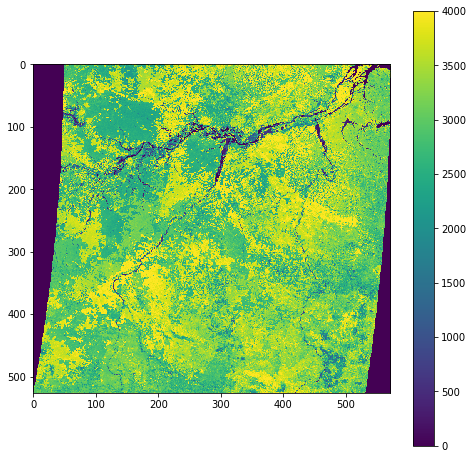

In [31]:
# resize using nn
resized_nir = scipy.ndimage.zoom(nir_arr, data.GetGeoTransform()[1] / cxres, order=0)
print resized_nir.shape, nir_arr.shape
plt.imshow(resized_nir)
plt.clim(0,4000)
_ = plt.colorbar()
print 'Ratio: ', xres / cxres

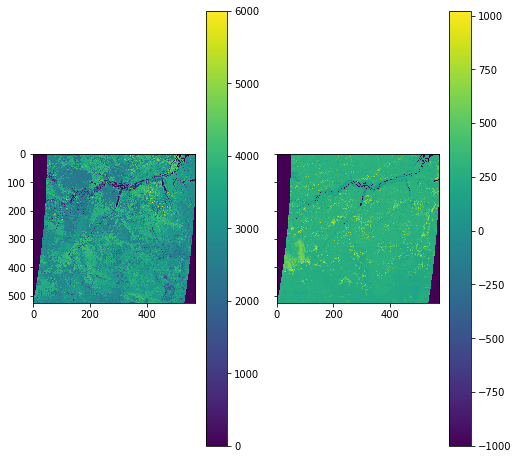

In [32]:
cutout_arr = cut.ReadAsArray()
s = cutout_arr.shape
# resize = resized_nir[:s[0], :s[1]]
cutout_arr[resized_nir == -1000] = -1000
f, ax = plt.subplots(1, 2)
ax[1].set_yticklabels([])
a = ax[0].imshow(resized_nir)
a.set_clim(vmin=0, vmax=6000)
b = ax[1].imshow(cutout_arr)
_ = f.colorbar(a, ax=ax[0])
_ = f.colorbar(b, ax=ax[1])


In [81]:
# Find closest goes-16 times
modis_time = filepath.split('.')[4][7:]
_time = datetime.datetime.strptime(modis_time, "%H%M%S")
# if _time.minute % 10 >= 5:
#     _time += datetime.timedelta(minutes=10 - _time.minute % 10)
# else:
#     _time += datetime.timedelta(minutes=-_time.minute % 10)
timendate = datetime.datetime.combine(date.date(), _time.time())
timendate.strftime('%Y-%m-%d %H:%M')
timendate

datetime.datetime(2017, 9, 14, 13, 27)

In [ ]:
for i, f in enumerate(veggies):
    f = os.path.basename(f)
    print f
    gyear = f[32:36]
    gdoy = f[36:39]
    gdate = datetime.datetime(int(gyear), 1, 1) + datetime.timedelta(int(gdoy) - 1)
    
    print gdoy, gyear, gdate